# Load and prepare the database

In [25]:
# install.packages('ape')
# install.packages('diversitree')
# install.packages('codetools')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
library(ape)

In [2]:
database_leafShape<-read.csv('../data_files/palm_leaf_shape_MFT_20221201.csv',sep='\t',header=TRUE)
colnames(database_leafShape)

[1] "species"        "subfamily"      "plication_all"  "shape_all"     
 [5] "polymorphism"   "dissection"     "pinnate"        "shape_gp"      
 [9] "shape_gp_num"   "induplicate"    "ind_variable"   "ind_cospalmate"
[13] "ind_pinnate"    "ind_entire"     "ind_bipinnate"  "reduplicate"   
[17] "red_variable"   "red_variance"   "red_cospalmate" "red_pinnate"   
[21] "red_entire"

In [3]:
tree_pos<-read.nexus('./Clean_1_1_MCCT_nexus.nex')

In [4]:
is.binary(tree_pos)

[1] TRUE

----------------
# 1- Diversification rate using MuSSE

#### Reduce database to induplicate/reduplicate

In [5]:
names(database_leafShape)
#"dissection" -> use for dissected vs entire models. binary
# "pinnate" -> binary -> 1 pinnates 0 palmates
#"shape_gp_num" -> third classification

[1] "species"        "subfamily"      "plication_all"  "shape_all"     
 [5] "polymorphism"   "dissection"     "pinnate"        "shape_gp"      
 [9] "shape_gp_num"   "induplicate"    "ind_variable"   "ind_cospalmate"
[13] "ind_pinnate"    "ind_entire"     "ind_bipinnate"  "reduplicate"   
[17] "red_variable"   "red_variance"   "red_cospalmate" "red_pinnate"   
[21] "red_entire"

In [6]:
dt<-database_leafShape[,c('species','pinnate')]
head(dt)
dim(dt) # dimentions

,species,pinnate
,<chr>,<int>
1,Saribus_brevifolius,0
2,Saribus_chocolatinus,0
3,Saribus_jeanneneyi,0
4,Saribus_merrillii,0
5,Saribus_papuanus,0
6,Saribus_rotundifolius,0


[1] 2648    2

In [7]:
which(is.na(dt[,2])) # all data coded

integer(0)

In [8]:
rownames(dt)<-dt[,1] # R is 1 indexed!

In [9]:
head(dt)

,species,pinnate
,<chr>,<int>
Saribus_brevifolius,Saribus_brevifolius,0
Saribus_chocolatinus,Saribus_chocolatinus,0
Saribus_jeanneneyi,Saribus_jeanneneyi,0
Saribus_merrillii,Saribus_merrillii,0
Saribus_papuanus,Saribus_papuanus,0
Saribus_rotundifolius,Saribus_rotundifolius,0


#### Species with no leaf shape information. 
- Removed from the analysis

In [10]:
# remove species that are not in the tree
list_taxa<-Reduce(intersect, list(tree_pos$tip.label,dt[,1]))

In [11]:
length(list_taxa)

[1] 2547

In [12]:
#missing_sp<-dt[which(apply(dt[,2:7],1,sum) == 0),1]
#missing_sp

In [15]:
#sorting trait data according to tree tip names order
dt<-dt[list_taxa,]
dim(dt)

[1] 2547    2

In [13]:
#reducing the tree in case there is missing data
tree<-drop.tip(tree_pos,setdiff(tree_pos$tip.label,list_taxa))
tree


Phylogenetic tree with 2547 tips and 2546 internal nodes.

Tip labels:
  Socratea_karstenii, Socratea_exorrhiza, Socratea_rostrata, Socratea_salazarii, Socratea_hecatonandra, Iriartella_setigera, ...

Rooted; includes branch lengths.

In [14]:
head(dt)

,species,pinnate
,<chr>,<int>
Saribus_brevifolius,Saribus_brevifolius,0
Saribus_chocolatinus,Saribus_chocolatinus,0
Saribus_jeanneneyi,Saribus_jeanneneyi,0
Saribus_merrillii,Saribus_merrillii,0
Saribus_papuanus,Saribus_papuanus,0
Saribus_rotundifolius,Saribus_rotundifolius,0


In [15]:
table(dt[,2])


   0    1 
 461 2187 

## Transform data into: 1 = palmates , 2= pinnates

#### pinnates -> "pinnate" + "pinnate - entire" + "bipinnates" + "polymorphic"
#### palmates -> "palmate" + "palmate - entire" + "cospalmates"

In [16]:
head(dt)

,species,pinnate
,<chr>,<int>
Saribus_brevifolius,Saribus_brevifolius,0
Saribus_chocolatinus,Saribus_chocolatinus,0
Saribus_jeanneneyi,Saribus_jeanneneyi,0
Saribus_merrillii,Saribus_merrillii,0
Saribus_papuanus,Saribus_papuanus,0
Saribus_rotundifolius,Saribus_rotundifolius,0


In [17]:
#musse model needs characters coded as 1, 2, 3, etc and not 0, 1 so:
dt2<-dt[,2]+1
names(dt2)<-dt[,1]
head(dt2)

Saribus_brevifolius  Saribus_chocolatinus    Saribus_jeanneneyi 
                    1                     1                     1 
    Saribus_merrillii      Saribus_papuanus Saribus_rotundifolius 
                    1                     1                     1

## Run MuSSE on a single tree - ALL MODELS (START)

In [18]:
#code for the trait classification -> used for generating file names in the end
trait_mod<-'pinVSpal'

In [19]:
library(diversitree)

In [20]:
trait<-dt2[tree$tip.label]
names(trait)<-tree$tip.label
length(trait)

[1] 2547

In [21]:
table(trait)

trait
   1    2 
 447 2100 

In [22]:
#find sensible starting points for the ML search
p<-starting.point.musse(tree,k=length(unique(trait)))
p

lambda1    lambda2        mu1        mu2        q12        q21 
0.21632382 0.21632382 0.13657865 0.13657865 0.01594903 0.01594903

In [23]:
#create the likelihood function
lik<-make.musse(tree,trait,k=length(unique(trait)),sampling.f=rep(1,length(unique(trait))))
argnames(lik)

[1] "lambda1" "lambda2" "mu1"     "mu2"     "q12"     "q21"

In [24]:
#constrained model based on all.free estimation
fit.free<-find.mle(lik, p[argnames(lik)])
fit.free$par

lambda1      lambda2          mu1          mu2          q12          q21 
0.2115507318 0.2173290670 0.1258563085 0.1388923481 0.0003308294 0.0001263966

In [25]:
save(fit.free,file=paste(trait_mod, 'pinVSpal_fit.free.Rdata', sep='_'))

In [26]:
#lamb constrained
lik.1<-constrain(lik,lambda2~lambda1)
fit.1<-find.mle(lik.1, p[argnames(lik.1)])
save(fit.1,file=paste(trait_mod, 'pinVSpal_fit.1.Rdata'))
fit.1$par

lambda1          mu1          mu2          q12          q21 
0.2163340566 0.1317829848 0.1376186191 0.0003301697 0.0001305570

In [27]:
#mu constrained
lik.2<-constrain(lik,mu2~mu1)
fit.2<-find.mle(lik.2, p[argnames(lik.2)])
save(fit.2,file=paste(trait_mod, 'pinVSpal_fit.2.Rdata'))
fit.2$par

lambda1      lambda2          mu1          q12          q21 
0.2187311640 0.2157931530 0.1366201026 0.0003230779 0.0001322729

In [28]:
#q constrained
lik.3<-constrain(lik, q21~q12)
fit.3<-find.mle(lik.3, p[argnames(lik.3)])
save(fit.3,file=paste(trait_mod, 'pinVSpal_fit.3.Rdata'))
fit.3$par

lambda1      lambda2          mu1          mu2          q12 
0.2128242534 0.2170657060 0.1279536708 0.1384067248 0.0001618153

In [29]:
#lamb and mu constrained
lik.4<-constrain(lik,lambda2~lambda1,mu2~mu1)
fit.4<-find.mle(lik.4, p[argnames(lik.4)])
save(fit.4,file=paste(trait_mod, 'pinVSpal_fit.4.Rdata'))
fit.4$par

lambda1          mu1          q12          q21 
0.2163300218 0.1365889638 0.0003044488 0.0001342051

In [30]:
#lamb and q constrained
lik.5<-constrain(lik,lambda2~lambda1,q21~q12)
fit.5<-find.mle(lik.5, p[argnames(lik.5)])
save(fit.5,file=paste(trait_mod, 'pinVSpal_fit.5.Rdata'))
fit.5$par

lambda1          mu1          mu2          q12 
0.2161186675 0.1319357851 0.1371115175 0.0001633958

In [31]:
#mu and q constrained
lik.6<-constrain(lik,mu2~mu1,q21~q12)
fit.6<-find.mle(lik.6, p[argnames(lik.6)])
save(fit.6,file=paste(trait_mod, 'pinVSpal_fit.6.Rdata'))
fit.6$par

lambda1      lambda2          mu1          q12 
0.2185825868 0.2158415790 0.1365722598 0.0001656127

In [32]:
lik_list<-list(lik, lik.1,lik.2,lik.3,lik.4,lik.5,lik.6)
model_list<-list(fit.free, fit.1,fit.2,fit.3,fit.4,fit.5,fit.6)
model_names<-list('fit.free','fit.1','fit.2','fit.3','fit.4','fit.5','fit.6')

In [33]:
fit.6$lnLik

[1] -7461.491

In [34]:
logLik_step1<-c()
AIC_step1<-c()
k<-c()
for(i in 1:length(model_list))
{
    logLik_step1<-rbind(logLik_step1,model_list[[i]]$lnLik)
    AIC_step1<-rbind(AIC_step1,AIC(model_list[[i]],k=length(model_list[[i]]$par)))
    k<-rbind(k,length(model_list[[i]]$par))
}

In [35]:
logLik_step1

-7461.148
-7461.189
-7461.258
-7461.420
-7461.315
-7461.442
-7461.491


In [36]:
rownames(logLik_step1)<-model_names
rownames(AIC_step1)<-model_names
rownames(k)<-model_names

In [37]:
AIC_step1<-sort(AIC_step1[,1],decreasing=FALSE)

In [38]:
AIC_step1

fit.4    fit.5    fit.6    fit.1    fit.2    fit.3 fit.free 
14938.63 14938.88 14938.98 14947.38 14947.52 14947.84 14958.30

------
## Best fitting model

In [39]:
best_fit<-model_list[[which(model_names==names(AIC_step1[1]))]]
best_lik<-lik_list[[which(model_names==names(AIC_step1[1]))]]

In [40]:
best_fit$par

lambda1          mu1          q12          q21 
0.2163300218 0.1365889638 0.0003044488 0.0001342051

In [41]:
best_fit

$par
     lambda1          mu1          q12          q21 
0.2163300218 0.1365889638 0.0003044488 0.0001342051 

$lnLik
[1] -7461.315

$counts
[1] 275

$convergence
[1] 0

$message
[1] "success! tolerance satisfied"

$hessian
NULL

$method
[1] "subplex"

$par.full
     lambda1      lambda2          mu1          mu2          q12          q21 
0.2163300218 0.2163300218 0.1365889638 0.1365889638 0.0003044488 0.0001342051 

$func.class
[1] "constrained" "musse"       "dtlik"       "function"   

attr(,"func")
MuSSE likelihood function:
  * Parameter vector takes 4 elements:
     - lambda1, mu1, q12, q21
  * Function constrained (original took 6 elements):
     - lambda2 ~ lambda1
     - mu2 ~ mu1
  * Function takes arguments (with defaults)
     - pars: Parameter vector
     - ...: Additional arguments to underlying function
     - pars.only [FALSE]: Return full parameter vector?
  * Phylogeny with 2547 tips and 2546 nodes
     - Taxa: Socratea_karstenii, Socratea_exorrhiza, ...
  * Referen

-------


## Ancestral state estimation based on MuSSE

In [42]:
st <- asr.marginal(best_lik, coef(best_fit))

In [43]:
head(st)

4.394057e-05,7.829685e-06,3.336603e-05,1.838927e-07,6.296185e-09,1.686865e-08,4.205054e-10,1.858175e-09,6.591238e-09,9.566975e-09,⋯,1.26722e-08,4.428663e-09,4.106281e-09,3.969666e-10,2.579016e-08,3.540794e-09,1.395753e-08,4.829331e-10,1.154292e-08,6.747683e-09
9.999561e-01,9.999922e-01,9.999666e-01,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,⋯,1.00000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [44]:
pdf(paste(trait_mod,'pinVSpal_ase_musse_best_backwardSelect.pdf',sep='_'),width=75,height=75)

par(mar=c(0,0,0,0))

#col<-c(
#rgb(alpha =0.6,0.211,0.211,0.211), 
#rgb(alpha =0.6,red=1,green=0.00,blue=0.0), 
#rgb(alpha =0.6,red=0,green=0,blue=1), 
#rgb(alpha =0.6,red=0,green=1,blue=0.0),
#rgb(alpha =0.6,red=230/255,green=0,blue=1),
#rgb(alpha =0.6,red=3/255,green=1,blue=248/255)
#rgb(alpha =0.6,red=3/255,green=1,blue=248/255)
#)

#1 = cos.palmate, 2 = pinnate, 3 = entire, 4 = polymorphic
#col=c("#15B0DE","#DD3D3D","#02C39A","#FBE279")

#1 = palmate, 2 = pinnate
col=c("#15B0DE","#DD3D3D")


plot.phylo(tree,edge.width=1,label.offset=1,cex=0.1,show.tip.label=T, type="fan")

nodelabels(pie=t(st), piecol=col, cex=0.2)
tiplabels(col=col[trait],pch=19,adj=1,cex=0.3) # trait datset must be sorted according to the tip.label order to be plotted correctly


#legend("topleft",legend=c("cos.palmate","pinnate", "bipinnate", "entire", "polymorphic"),
legend("topleft",legend=c("palmate","pinnate"),
cex=10,
col= col,
text.col=col,
,pt.cex=10,pch=15,box.lwd=0)


dev.off()

png 
  2

------

## MCMC MuSSE

#### on the MCC tree only
#### best model only
#### starting parameters are the ML estimates

In [45]:
#find sensible starting points for the ML search
p

lambda1    lambda2        mu1        mu2        q12        q21 
0.21632382 0.21632382 0.13657865 0.13657865 0.01594903 0.01594903

In [46]:
prior <- make.prior.exponential(1 / (2 * (p[1] - p[3])))

the tuning parameter w affects how many function evaluations are required between sample updates, but in almost all cases it does not affect how fast the MCMC “mixes” (Neal 2003). In particular, w is not analagous to the step sizes used in conventional Metropolis-Hastings updaters that use some fixed kernel for updates (see below). Ideally, w would be set to approximately the width of the high probability region. I find that chosing the distance between the 5% and 95% quantiles of the marginal distributions of each parameter works well, computed from this preliminary set of samples (see Examples). If a single value is given, this is shared across all parameters.

If a vector is given, then it must be the same length as w, and parameter i will use w[i]

In [47]:
#The “stepsize” (argument w) for the mcmc needs to be carefully tuned. To do so we run a short chain and use the range of observed samples as a measure of this.
# https://rdrr.io/cran/diversitree/man/mcmc.html
# best_lik = likelihood function
# best_fit$par = initial state. parameters of the best fit model
# w = Tuning parameter for the sampler

tmp <- mcmc(best_lik, best_fit$par, nsteps=150, prior=prior,lower=0, w=rep(1, length(best_fit$par)), print.every=0)


In [48]:
head(tmp)

,i,lambda1,mu1,q12,q21,p
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.2176611,0.1384821,0.0007628595,0.0001834885,-7456.838
2,2,0.2196058,0.1358379,0.0003840646,0.0001725464,-7456.959
3,3,0.2210227,0.1411256,0.0002904623,0.0003086736,-7457.403
4,4,0.2170828,0.1345854,0.0003559898,0.0002386676,-7456.814
5,5,0.2171956,0.1446714,0.0015021529,0.0002725237,-7460.303
6,6,0.2207148,0.1448740,0.0018137154,0.0003257004,-7460.610


In [49]:
tmp[2:ncol(tmp)] # assuming that the length of w has to be the same as the number of parameters

lambda1,mu1,q12,q21,p
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2176611,0.1384821,7.628595e-04,1.834885e-04,-7456.838
0.2196058,0.1358379,3.840646e-04,1.725464e-04,-7456.959
0.2210227,0.1411256,2.904623e-04,3.086736e-04,-7457.403
0.2170828,0.1345854,3.559898e-04,2.386676e-04,-7456.814
0.2171956,0.1446714,1.502153e-03,2.725237e-04,-7460.303
0.2207148,0.1448740,1.813715e-03,3.257004e-04,-7460.610
0.2226705,0.1465981,1.131018e-03,9.438478e-05,-7458.119
0.2243027,0.1464308,4.035295e-04,3.136624e-04,-7457.812
0.2204327,0.1340172,3.247060e-04,2.645013e-04,-7458.395


In [50]:
 # we need to remove the p column because is the likelihood probability and not a parameter. To get w, we need only the parameters
tmp[2:(ncol(tmp)-1)]

lambda1,mu1,q12,q21
<dbl>,<dbl>,<dbl>,<dbl>
0.2176611,0.1384821,7.628595e-04,1.834885e-04
0.2196058,0.1358379,3.840646e-04,1.725464e-04
0.2210227,0.1411256,2.904623e-04,3.086736e-04
0.2170828,0.1345854,3.559898e-04,2.386676e-04
0.2171956,0.1446714,1.502153e-03,2.725237e-04
0.2207148,0.1448740,1.813715e-03,3.257004e-04
0.2226705,0.1465981,1.131018e-03,9.438478e-05
0.2243027,0.1464308,4.035295e-04,3.136624e-04
0.2204327,0.1340172,3.247060e-04,2.645013e-04


sapply() function takes list, vector or data frame as input and gives output in vector or matrix. It is useful for operations on list objects and returns a list object of same length of original set. 

Range in R returns a vector that contains the minimum and maximum values of the given argument

In [51]:
sapply(tmp[2:(ncol(tmp)-1)], range)

lambda1,mu1,q12,q21
0.2001546,0.1164301,2.956132e-05,1.144095e-05
0.2331048,0.1578298,2.164111e-03,6.379337e-04


In [52]:
diff(sapply(tmp[2:(ncol(tmp)-1)], range)) # returns a vector with the differences

lambda1,mu1,q12,q21
0.03295025,0.04139976,0.002134549,0.0006264928


In [53]:
w <- diff(sapply(tmp[2:(ncol(tmp)-1)], range))
w

lambda1,mu1,q12,q21
0.03295025,0.04139976,0.002134549,0.0006264928


In [54]:
#run the mcmc
samples <- mcmc(best_lik, best_fit$par, nsteps=3000, w=w, lower=0, prior=prior,print.every=200)

200: {0.2203, 0.1434, 0.0010, 0.0001} -> -7457.57300
400: {0.2252, 0.1376, 0.0009, 0.0003} -> -7460.85583
600: {0.2217, 0.1474, 0.0007, 0.0001} -> -7457.97248
800: {0.2323, 0.1517, 0.0006, 0.0002} -> -7459.31696
1000: {0.2192, 0.1405, 0.0001, 0.0003} -> -7457.78832
1200: {0.2214, 0.1338, 0.0002, 0.0008} -> -7464.42823
1400: {0.1983, 0.1228, 0.0007, 0.0001} -> -7461.38403
1600: {0.2143, 0.1287, 0.0002, 0.0002} -> -7457.04664
1800: {0.2109, 0.1240, 0.0005, 0.0001} -> -7457.40194
2000: {0.2048, 0.1221, 0.0007, 0.0002} -> -7457.76755
2200: {0.2132, 0.1328, 0.0001, 0.0001} -> -7457.45032
2400: {0.2255, 0.1499, 0.0005, 0.0002} -> -7457.54282
2600: {0.2088, 0.1264, 0.0004, 0.0001} -> -7456.62390
2800: {0.2209, 0.1353, 0.0004, 0.0001} -> -7457.87620
3000: {0.2274, 0.1511, 0.0001, 0.0002} -> -7458.11109


In [55]:
write.table(samples,paste(trait_mod, 'mcmc_2000gen_MCC_bestfit_pinnate_vs_palmate.txt', sep='_'),sep=';')

In [56]:
head(samples)

,i,lambda1,mu1,q12,q21,p
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.2181797,0.1418896,0.0003003000,0.0002187918,-7456.784
2,2,0.2214263,0.1460085,0.0007787353,0.0002462612,-7457.739
3,3,0.2225945,0.1502132,0.0006659550,0.0002930171,-7458.702
4,4,0.2244738,0.1510758,0.0001700237,0.0003493676,-7458.860
5,5,0.2265543,0.1464441,0.0011883633,0.0002489112,-7459.178
6,6,0.2191964,0.1490745,0.0001592408,0.0001888877,-7458.804


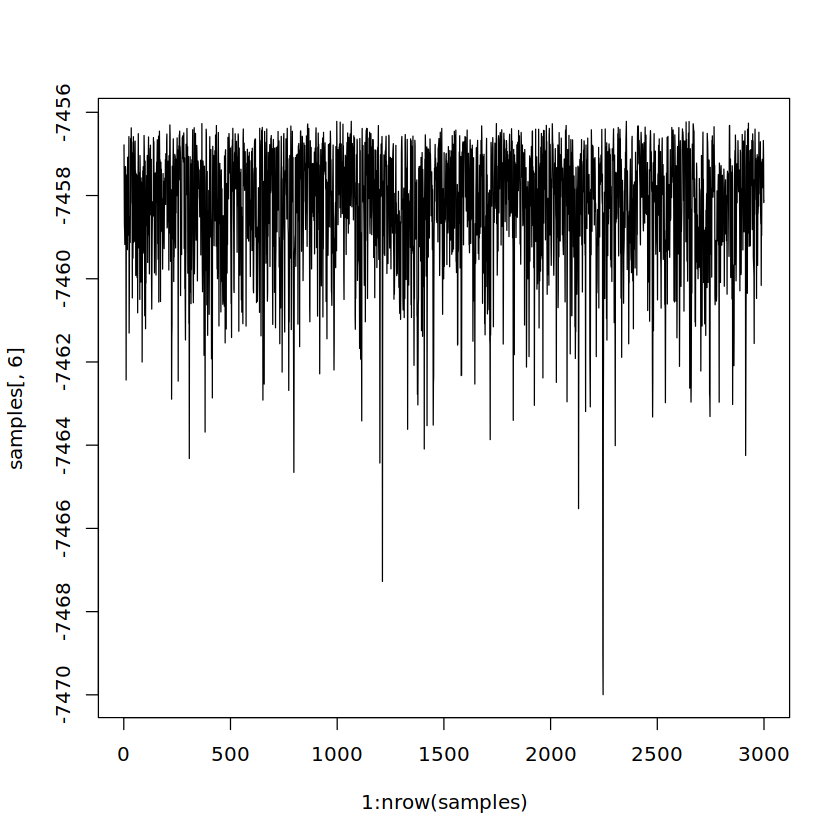

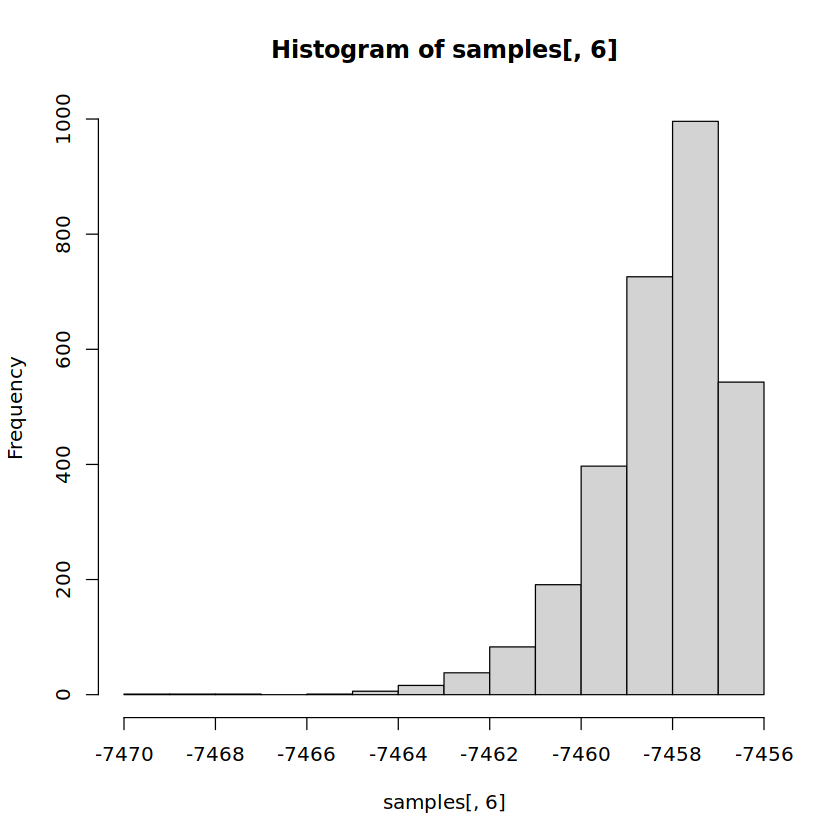

In [57]:
#check mcmc trace for parameters
#remove suitable burnin fraction

plot(1:nrow(samples),samples[,6],type="l")
hist(samples[,6])

#### For plotting parameter posterior distribution. This needs to be changed manually according to parameters contained in the best models. I can do later with output files.

In [ ]:
# pdf("lambda_mcmc_postdis_best_MCC_dissected_entire.pdf",width=6,height=6)
# #plot posterior distributions of parameters
# profiles.plot(samples[c("lambda2", "lambda4")], col.line=c("grey",col[4]), las=1)
# legend("topright",legend=c("cos.palmate","pinnate", "entire", "polymorphic"),
# col= c("grey","grey","grey",col[4]),
# text.col=c("grey","grey","grey",col[4]),
# ,pt.cex=2,pch=15,box.lwd=0)
# dev.off()

In [104]:
pdf('pinVSpal_lambda_mcmc_postdis_best_MCC.pdf',width=6,height=6)
#plot posterior distributions of parameters
profiles.plot(samples[c('lambda1')], col.line=c('grey'), las=1)
legend('topright',legend=c('pinnate','palmate'),
col= c('grey'),
text.col=c('grey'),
,pt.cex=2,pch=15,box.lwd=0)
dev.off()

png 
  2

In [106]:
pdf('pinVSpal_mu_mcmc_postdis_best_MCC.pdf',width=6,height=6)
#plot posterior distributions of parameters
profiles.plot(samples[c('mu1')], col.line=c(col[1],col[2],'grey'), las=1)
legend('topright',legend=c('pinnate', 'palmate'),
col= c(col[1],col[2],'grey','grey'),
text.col=c(col[1],col[2],'grey','grey'),
,pt.cex=2,pch=15,box.lwd=0)
dev.off()

png 
  2

In [ ]:
net_div_t<-cbind(samples[,2]-samples[,4],samples[,2]-samples[,5],samples[,2]-samples[,6],samples[,3]-samples[,6])
head(net_div_t)

In [ ]:
pdf("netdiv_mcmc_postdis_best_MCC.pdf",width=6,height=6)
#plot posterior distributions of parameters
profiles.plot(net_div_t, col.line=col, las=1)
legend("topright",legend=c("cos.palmate","pinnate", "entire", "polymorphic"),
col= col,
text.col=col,
,pt.cex=2,pch=15,box.lwd=0)
dev.off()

In [ ]:
pdf("q_mcmc_postdis_best_MCC.pdf",width=6,height=6)
#1 = cos.palmate, 2 = pinnate, 3 = entire, 4 = polymorphic
col=c("#15B0DE","#DD3D3D","#02C39A","#FBE279")

#q21 ~ q12, q24 ~ q12, q31 ~ q12, q23 ~ q13, q43 ~ q13

#plot posterior distributions of parameters
profiles.plot(log(samples[c("q12", "q13", "q34", "q42")]), col.line=c("#FBE279","darkorange","red","saddlebrown"), las=1)
legend("topleft",legend=c("cos->pin", "pin->cos", "pin->poly", "ent->cos", 
                          "cos->ent", "pin->ent", "poly->ent",
                            "ent->poly", 
                            "poly->pin"
                          ),
col= c("#FBE279","#FBE279","#FBE279","#FBE279","darkorange","darkorange","darkorange","red","saddlebrown"),
text.col=c("#FBE279","#FBE279","#FBE279","#FBE279","darkorange","darkorange","darkorange","red","saddlebrown"),
,pt.cex=2,pch=15,box.lwd=0)
dev.off()

-----
# Repeat the best model on a posterior distribution of trees

In [58]:
tree_samp<-read.tree('sampled_trees_100.nex')

In [59]:
T<-100

In [60]:
best_fit$par
best_lik

lambda1          mu1          q12          q21 
0.2163300218 0.1365889638 0.0003044488 0.0001342051

MuSSE likelihood function:
  * Parameter vector takes 4 elements:
     - lambda1, mu1, q12, q21
  * Function constrained (original took 6 elements):
     - lambda2 ~ lambda1
     - mu2 ~ mu1
  * Function takes arguments (with defaults)
     - pars: Parameter vector
     - ...: Additional arguments to underlying function
     - pars.only [FALSE]: Return full parameter vector?
  * Phylogeny with 2547 tips and 2546 nodes
     - Taxa: Socratea_karstenii, Socratea_exorrhiza, ...
  * Reference:
     - FitzJohn (submitted)
R definition:
function (pars, ..., pars.only = FALSE)

In [61]:
for(t in 1:T)
{
    tree_t<-tree_samp[[t]]
    tree_t<-drop.tip(tree_t,setdiff(tree_t$tip.label,names(trait)))
    
    trait<-dt2[tree_t$tip.label]
    names(trait)<-tree_t$tip.label
    
    p<-starting.point.musse(tree_t,k=length(unique(trait)))
        
    fit.best_t<-find.mle(best_lik, p[argnames(best_lik)])
    
    save(fit.best_t,file=paste(trait_mod,'pinVSpal_fit.best_t_tree',t,'.Rdata',sep=""))
}


In [62]:
#pdf("asr_best_model_postdis.pdf",width=75,height=75)

par_post_dis<-c()
root_state_prob<-c()

for(t in 1:T)
{   
    tree_t<-tree_samp[[t]]
    tree_t<-drop.tip(tree_t,setdiff(tree_t$tip.label,list_taxa))

    trait<-dt2[tree_t$tip.label]
    names(trait)<-tree_t$tip.label

    tip_data<-cbind(1:Ntip(tree_t), trait, 1)

    p<-starting.point.musse(tree_t,k=length(unique(trait)))
    
    load(file=paste(trait_mod,'pinVSpal_fit.best_t_tree',t,'.Rdata',sep=""))
    
    st <- asr.marginal(best_lik, coef(fit.best_t))
    st.mtx<-t(st)
        
    par_post_dis<-rbind(par_post_dis,fit.best_t$par)
    root_state_prob<-rbind(root_state_prob,t(st)[1,])

    par(mar=c(0,0,0,0))

    
#1 = palmate, 2 = pinnate
#col=c("#15B0DE","#DD3D3D")

#plot.phylo(tree_t,edge.width=1,label.offset=1,cex=0.1,show.tip.label=T, type="fan")

#nodelabels(pie=t(st), piecol=col, cex=0.2)
#tiplabels(col=col[trait],pch=19,adj=1,cex=0.3) # trait datset must be sorted according to the tip.label order to be plotted correctly


#legend("topleft",legend=c("cos.palmate","pinnate", "bipinnate", "entire", "polymorphic"),
#legend("topleft",legend=c("palmate","pinnate"),
#cex=10,
#col= col,
#text.col=col,
#,pt.cex=10,pch=15,box.lwd=0)

}

#dev.off()



In [63]:
#relative probability of character states at the root across 100 trees
head(root_state_prob)

4.884990e-05,0.9999512
7.232525e-05,0.9999277
5.262562e-05,0.9999474
5.916048e-05,0.9999408
5.041397e-05,0.9999496
4.301687e-05,0.9999570


In [64]:
length(root_state_prob)

[1] 200

In [65]:
#ML estimates of model parameters across 100 trees
head(par_post_dis)

lambda1,mu1,q12,q21
0.2163305,0.1365884,0.0003184790,0.0001314585
0.2163428,0.1365951,0.0003737275,0.0001197378
0.2163063,0.1365648,0.0003293328,0.0001341602
0.2163117,0.1365674,0.0003459683,0.0001321137
0.2163070,0.1365634,0.0003234671,0.0001355392
0.2163414,0.1365804,0.0003013239,0.0001318500


In [66]:
write.table(par_post_dis, paste(trait_mod,"pinVSpal_par_post_dis.txt",sep="_"),row.names = FALSE)
write.table(root_state_prob, paste(trait_mod,"pinVSpal_root_state_prob.txt",sep="_"),row.names = FALSE)

In [67]:
pdf(paste(trait_mod,"pinVSpal_root_state_prob_postdis.pdf",sep="_"),width=6,height=6)

#1 = palmate, 2 = pinnate
col=c("#15B0DE","#DD3D3D")

#plot posterior distributions of parameters
profiles.plot(root_state_prob[,c(1,2)], col.line=col, las=1)
legend("topright",legend=c("palmate","pinnate"),
col= col,
text.col=col,
,pt.cex=2,pch=15,box.lwd=0)

abline(v=apply(root_state_prob, MARGIN=2, FUN=median), col=col, lwd=2)

dev.off()

Warning message in arrows(ci[[i]][1], z[i], ci[[i]][2], z[i], code = 3, angle = 90, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(ci[[i]][1], z[i], ci[[i]][2], z[i], code = 3, angle = 90, :
“zero-length arrow is of indeterminate angle and so skipped”


png 
  2

#### For plotting parameter posterior distribution. This needs to be changed manually according to parameters contained in the best models. I can do later with output files.

In [68]:
head(par_post_dis)

lambda1,mu1,q12,q21
0.2163305,0.1365884,0.0003184790,0.0001314585
0.2163428,0.1365951,0.0003737275,0.0001197378
0.2163063,0.1365648,0.0003293328,0.0001341602
0.2163117,0.1365674,0.0003459683,0.0001321137
0.2163070,0.1365634,0.0003234671,0.0001355392
0.2163414,0.1365804,0.0003013239,0.0001318500


In [78]:
pdf("pinVSpal_lambda_tree_postdis_best.pdf",width=6,height=6)

#1 = cos.palmate, 2 = pinnate, 3 = entire, 4 = polymorphic
# col=c("#15B0DE","#DD3D3D","#02C39A","#FBE279")

#1 = palmate, 2 = pinnate
col=c("#15B0DE","#DD3D3D")

#plot posterior distributions of parameters
# profiles.plot(par_post_dis[,c(1,1)], col.line=c(col[1],col[2]), las=1) # lambda is the same for both, merged lambda1 and 2
profiles.plot(par_post_dis[,c(1,1)], col.line=c(col[1],col[2]), las=1) # lambda is the same for both, merged lambda1 and 2
legend("topright",legend=c("palmate and pinnate"),
col= c(col[1],col[2]),
text.col=c(col[1],col[2]),
,pt.cex=2,pch=15,box.lwd=0)

dev.off()

pdf("pinVSpal_mu_tree_postdis_best.pdf",width=6,height=6)

#plot posterior distributions of parameters
# profiles.plot(par_post_dis[,c(2,2)], col.line=c(col[1],col[2]), las=1)
profiles.plot(par_post_dis[,c(2,2)], col.line=c(col[1],col[2]), las=1)
legend("topright",legend=c("palmate and pinnate"),
col= c(col[1],col[2]),
text.col=c(col[1],col[2]),
,pt.cex=2,pch=15,box.lwd=0)
col= c(col[1],col[2])

dev.off()

net_div_posdis<-cbind(par_post_dis[,1]-par_post_dis[,2]) # there's only one
head(net_div_posdis)



pdf("pinVSpal_netdiv_tree_postdis_best.pdf",width=6,height=6)

#plot posterior distributions of parameters
profiles.plot(net_div_posdis, col.line=col, las=1)
legend("topright",legend=c("palmate and pinnate"),
col= col,
text.col=col,
,pt.cex=2,pch=15,box.lwd=0)

dev.off()

pdf("pinVSpal_q_tree_postdis_best.pdf",width=6,height=6)

#plot posterior distributions of parameters
profiles.plot(log(par_post_dis[,c(3,4)]), col.line=c("darkorange","red"), las=1)
legend("topleft",legend=c("pal->pin", "pin->pal"),
col= c("darkorange","red"),
text.col=c("darkorange","red"),
,pt.cex=2,pch=15,box.lwd=0)

dev.off()

png 
  2

png 
  2

0.07974211
0.07974775
0.07974143
0.07974425
0.07974355
0.07976091


png 
  2

png 
  2

--------------------------
# ML fitting on different starting parameters

In [79]:
lambda_p_range<-c(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4)
mu_p_range<-c(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4)
q_p_range<-c(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4)

In [80]:
p

lambda1    lambda2        mu1        mu2        q12        q21 
0.21073021 0.21073021 0.12514814 0.12514814 0.01711641 0.01711641

In [81]:
best_fit$par

lambda1          mu1          q12          q21 
0.2163300218 0.1365889638 0.0003044488 0.0001342051

In [82]:
par_lambda_range<-c()
par_mu_range<-c()
par_q_range<-c()
for(i in 1:1)
#for(i in 1:length(lambda_p_range))
{
    fit.i<-find.mle(best_lik, c(lambda_p_range[i],p[c(2,3,4)]))
    par_lambda_range<-rbind(par_lambda_range,fit.i$par)

    fit.i<-find.mle(best_lik, c(p[c(1)],mu_p_range[i],p[c(3,4)]))
    par_mu_range<-rbind(par_mu_range,fit.i$par)

    fit.j<-find.mle(best_lik, c(p[c(1,2)], q_p_range[i],q_p_range[i]))
    par_q_range<-rbind(par_q_range,fit.j$par)
}

In [83]:
colnames(par_lambda_range)<-colnames(par_mu_range)<-colnames(par_q_range)<-c("lambda1","mu1","q12","q21")

In [84]:
write.table(par_lambda_range,paste(trait_mod,"pinVSpal_par_lambda_range.txt",sep="_"),row.names = FALSE)
write.table(par_mu_range,paste(trait_mod,"pinVSpal_par_mu_range.txt",sep="_"),row.names = FALSE)
write.table(par_q_range,paste(trait_mod,"pinVSpal_par_q_range.txt",sep="_"),row.names = FALSE)

#### I will deal with the plotting later  if you want

----------------
# 2- Diversification rate using HiSSE

In [35]:
library(hisse)


Loading required package: deSolve
Loading required package: GenSA
Loading required package: subplex
Loading required package: nloptr


In [ ]:
0 1

A B

0A 0B 1A 1B



In [36]:
trait<-dt2[tree$tip.label]-1
trait<-cbind(tree$tip.label,trait)
rownames(trait)<-tree$tip.label
length(trait)

[1] 5094

In [37]:
#0A != 1A != 0B != 1B
turnover.allfree = c(1,2,3,4)
eps.allfree = c(1,2,3,4)

#0A = 1A != 0B = 1B => div rate difference between hidden states
turnover.hidfree = c(1,1,2,2)
eps.hidfree = c(1,1,2,2)

#0A = 0B != 1A = 1B => div rate difference between observed states
turnover.obsfree = c(1,2,1,2)
eps.obsfree = c(1,2,1,2)


#0A = 0B = 1A = 1B => NO div rate difference at all
turnover.allequal = c(1,1,1,1)
eps.allequal = c(1,1,1,1)


In [38]:
trans.rates = TransMatMaker(hidden.states=TRUE)
trans.rates

,(0A),(1A),(0B),(1B)
(0A),NA,4,7,10
(1A),1,NA,8,11
(0B),2,5,NA,12
(1B),3,6,9,NA


In [39]:
#remove simultaneous transition of both observed and hidden states
trans.rates.nodual = ParDrop(trans.rates, c(3,5,8,10))
trans.rates.nodual

,(0A),(1A),(0B),(1B)
(0A),NA,3,5,0
(1A),1,NA,0,7
(0B),2,0,NA,8
(1B),0,4,6,NA


In [40]:
trans.rates.nodual.allequal = ParEqual(trans.rates.nodual, c(1,2,1,3,1,4,1,5,1,6,1,7,1,8))
trans.rates.nodual.allequal

#0A->1A=1A->0A != 0B->1B=1B->0B
trans.rates.nodual.1 = ParEqual(trans.rates.nodual, c(1,3))
trans.rates.nodual.1.1 = ParEqual(trans.rates.nodual.1, c(2,3,2,4,2,6))
trans.rates.nodual.1.1

trans.rates.nodual.1.2 = ParEqual(trans.rates.nodual.1.1, c(3,4))
trans.rates.nodual.1.2

trans.rates.nodual.1.3 = ParEqual(trans.rates.nodual, c(2,4,2,5,2,7))
trans.rates.nodual.1.4 = ParEqual(trans.rates.nodual.1.3, c(4,5))
trans.rates.nodual.1.4


,(0A),(1A),(0B),(1B)
(0A),NA,1,1,0
(1A),1,NA,0,1
(0B),1,0,NA,1
(1B),0,1,1,NA


,(0A),(1A),(0B),(1B)
(0A),NA,1,2,0
(1A),1,NA,0,2
(0B),2,0,NA,4
(1B),0,2,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,1,2,0
(1A),1,NA,0,2
(0B),2,0,NA,3
(1B),0,2,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,3,2,0
(1A),1,NA,0,2
(0B),2,0,NA,4
(1B),0,2,4,NA


In [41]:
#0A->0B=0B->0A != 1A->1B=1B->1A
#trans.rates.nodual.2 = ParEqual(trans.rates.nodual, c(2,5))
#trans.rates.nodual.2 = ParEqual(trans.rates.nodual.2, c(1,3,1,5,1,7))
#trans.rates.nodual.2 = ParEqual(trans.rates.nodual.2, c(3,4))
#trans.rates.nodual.2

In [42]:
trans.rates.nodual.allequal = ParEqual(trans.rates.nodual, c(1,2,1,3,1,4,1,5,1,6,1,7,1,8))

#1 free transition models
trans.rates.nodual.3 = ParEqual(trans.rates.nodual, c(1,2,1,3,1,4,1,5,1,6,1,7))
trans.rates.nodual.3
trans.rates.nodual.4 = ParEqual(trans.rates.nodual, c(1,2,1,3,1,4,1,5,1,7,1,8))
trans.rates.nodual.4
trans.rates.nodual.5 = ParEqual(trans.rates.nodual, c(1,2,1,4,1,5,1,6,1,7,1,8))
trans.rates.nodual.5
trans.rates.nodual.6 = ParEqual(trans.rates.nodual, c(2,3,2,4,2,5,2,6,2,7,2,8))
trans.rates.nodual.6

,(0A),(1A),(0B),(1B)
(0A),NA,1,1,0
(1A),1,NA,0,1
(0B),1,0,NA,2
(1B),0,1,1,NA


,(0A),(1A),(0B),(1B)
(0A),NA,1,1,0
(1A),1,NA,0,1
(0B),1,0,NA,1
(1B),0,1,2,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,1,0
(1A),1,NA,0,1
(0B),1,0,NA,1
(1B),0,1,1,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,2,0
(1A),1,NA,0,2
(0B),2,0,NA,2
(1B),0,2,2,NA


In [43]:
#2 free transition models
trans.rates.nodual.7 = ParEqual(trans.rates.nodual, c(1,2,1,3,1,4,1,5,1,7))
trans.rates.nodual.7
trans.rates.nodual.8 = ParEqual(trans.rates.nodual, c(1,2,1,4,1,5,1,6,1,7))
trans.rates.nodual.8
trans.rates.nodual.9 = ParEqual(trans.rates.nodual, c(2,3,2,4,2,5,2,6,2,7))
trans.rates.nodual.9

trans.rates.nodual.10 = ParEqual(trans.rates.nodual, c(1,2,1,4,1,5,1,7,1,8))
trans.rates.nodual.10
trans.rates.nodual.11 = ParEqual(trans.rates.nodual, c(2,3,2,4,2,5,2,7,2,8))
trans.rates.nodual.11

trans.rates.nodual.12 = ParEqual(trans.rates.nodual, c(2,4,2,5,2,6,2,7,2,8))
trans.rates.nodual.12

,(0A),(1A),(0B),(1B)
(0A),NA,1,1,0
(1A),1,NA,0,1
(0B),1,0,NA,3
(1B),0,1,2,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,1,0
(1A),1,NA,0,1
(0B),1,0,NA,3
(1B),0,1,1,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,2,0
(1A),1,NA,0,2
(0B),2,0,NA,3
(1B),0,2,2,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,1,0
(1A),1,NA,0,1
(0B),1,0,NA,1
(1B),0,1,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,2,0
(1A),1,NA,0,2
(0B),2,0,NA,2
(1B),0,2,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,3,2,0
(1A),1,NA,0,2
(0B),2,0,NA,2
(1B),0,2,2,NA


In [44]:
#3 free transition models
trans.rates.nodual.13 = ParEqual(trans.rates.nodual, c(1,2,1,4,1,5,1,7))
trans.rates.nodual.13
trans.rates.nodual.14 = ParEqual(trans.rates.nodual, c(2,3,2,4,2,5,2,7))
trans.rates.nodual.14

trans.rates.nodual.15 = ParEqual(trans.rates.nodual, c(2,4,2,5,2,7,2,8))
trans.rates.nodual.15

,(0A),(1A),(0B),(1B)
(0A),NA,2,1,0
(1A),1,NA,0,1
(0B),1,0,NA,4
(1B),0,1,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,2,2,0
(1A),1,NA,0,2
(0B),2,0,NA,4
(1B),0,2,3,NA


,(0A),(1A),(0B),(1B)
(0A),NA,3,2,0
(1A),1,NA,0,2
(0B),2,0,NA,2
(1B),0,2,4,NA


In [45]:
#4 free transition models
trans.rates.nodual.16 = ParEqual(trans.rates.nodual, c(2,4,2,5,2,7))
trans.rates.nodual.16

,(0A),(1A),(0B),(1B)
(0A),NA,3,2,0
(1A),1,NA,0,2
(0B),2,0,NA,5
(1B),0,2,4,NA


In [46]:
trans.rates.nodual

,(0A),(1A),(0B),(1B)
(0A),NA,3,5,0
(1A),1,NA,0,7
(0B),2,0,NA,8
(1B),0,4,6,NA


In [47]:
trans_list<-list(trans.rates.nodual,
trans.rates.nodual.allequal,
trans.rates.nodual.1.1,
trans.rates.nodual.1.2,
trans.rates.nodual.1.4,
trans.rates.nodual.3,
trans.rates.nodual.4,
trans.rates.nodual.5,
trans.rates.nodual.6,
trans.rates.nodual.7,
trans.rates.nodual.8,
trans.rates.nodual.9,
trans.rates.nodual.10,
trans.rates.nodual.11,
trans.rates.nodual.12,
trans.rates.nodual.13,
trans.rates.nodual.14,
trans.rates.nodual.15,
trans.rates.nodual.16)

trans_names<-c("trans.rates.nodual",
"trans.rates.nodual.allequal",
"trans.rates.nodual.1.1",
"trans.rates.nodual.1.2",
"trans.rates.nodual.1.4",
"trans.rates.nodual.3",
"trans.rates.nodual.4",
"trans.rates.nodual.5",
"trans.rates.nodual.6",
"trans.rates.nodual.7",
"trans.rates.nodual.8",
"trans.rates.nodual.9",
"trans.rates.nodual.10",
"trans.rates.nodual.11",
"trans.rates.nodual.12",
"trans.rates.nodual.13",
"trans.rates.nodual.14",
"trans.rates.nodual.15",
"trans.rates.nodual.16")

In [48]:
turnover_list<-list(
    turnover.allfree,
    turnover.hidfree,
    turnover.obsfree,
    turnover.allequal
)

turnover_names<-c(
    "turnover.allfree",
    "turnover.hidfree",
    "turnover.obsfree",
    "turnover.allequal"
)

eps_list<-list(
    eps.allfree,
    eps.hidfree,
    eps.obsfree,
    eps.allequal
)

eps_names<-c(
    "eps.allfree",
    "eps.hidfree",
    "eps.obsfree",
    "eps.allequal"
)

In [49]:
trait_mod<-"pinVSpal"

In [174]:
m1 = hisse(tree, trait, f=c(1,1), hidden.states=TRUE, turnover.anc=turnover_list[[1]], 
           eps.anc=eps_list[[1]], trans.rate=trans_list[[1]])

Initializing... 
Finished. Beginning bounded subplex routine... 
Finished. Summarizing results... 


In [175]:
save(m1,file=paste(trait_mod,turnover_names[1],eps_names[1],trans_names[1], "fit.hisse.Rdata", sep="_"))

In [50]:
load(paste(trait_mod,turnover_names[1],eps_names[1],trans_names[1], "fit.hisse.Rdata", sep="_"))


In [51]:
m1


Fit
       lnL      AIC     AICc ntax
 -7240.676 14513.35 14513.57 2547

Probability of extinction: 

Diversification Rates
                    turnover  ext.frac
rate0A             0.1494639 0.6181761
alpha0A            1.0000000 1.0000000
beta0A             1.0000000 1.0000000
timeslice.factor0A 1.0000000 1.0000000

                   turnover ext.frac
rate1A             9.881495 2.877659
alpha1A            1.000000 1.000000
beta1A             1.000000 1.000000
timeslice.factor1A 1.000000 1.000000

                    turnover  ext.frac
rate0B             0.4047937 0.2641867
alpha0B            1.0000000 1.0000000
beta0B             1.0000000 1.0000000
timeslice.factor0B 1.0000000 1.0000000

                    turnover  ext.frac
rate1B             0.3290119 0.5796047
alpha1B            1.0000000 1.0000000
beta1B             1.0000000 1.0000000
timeslice.factor1B 1.0000000 1.0000000

Transition Rates
             (0A)        (1A)        (0B)         (1B)
(0A)           NA 3.49307e-09

In [177]:
m1$AIC

[1] 14513.35

In [ ]:
m1.recon = MarginRecon(tree, trait, f=c(1,1), hidden.states=TRUE, pars=m1$solution, 
                       n.cores=3)

In [ ]:
m1.recon

In [ ]:
for(i in 1:length(turnover_list))
    {
    for(j in 1:length(trans_list))
        {
            m = hisse(tree, trait, f=c(1,1), hidden.states=TRUE, turnover.anc=turnover_list[[i]], 
           eps.anc=eps_list[[i]], trans.rate=trans_list[[j]])
            save(m,file=paste(trait_mod,turnover_names[i],eps_names[i],trans_names[j], "fit.hisse.Rdata", sep="_"))
    }
}